
Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f277b3ca3d0>]],
      dtype=object)

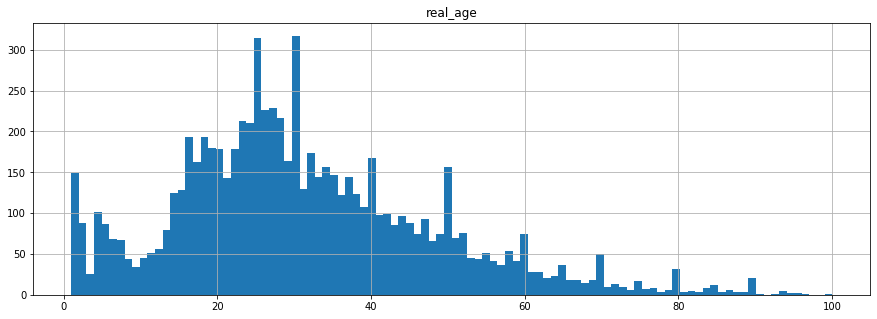

In [2]:
labels.hist(bins=100, figsize=(15,5))

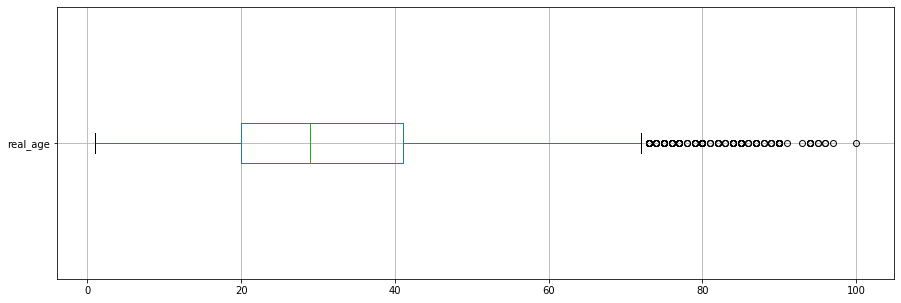

In [8]:
labels.boxplot(figsize=(15,5), vert=False)

In [15]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


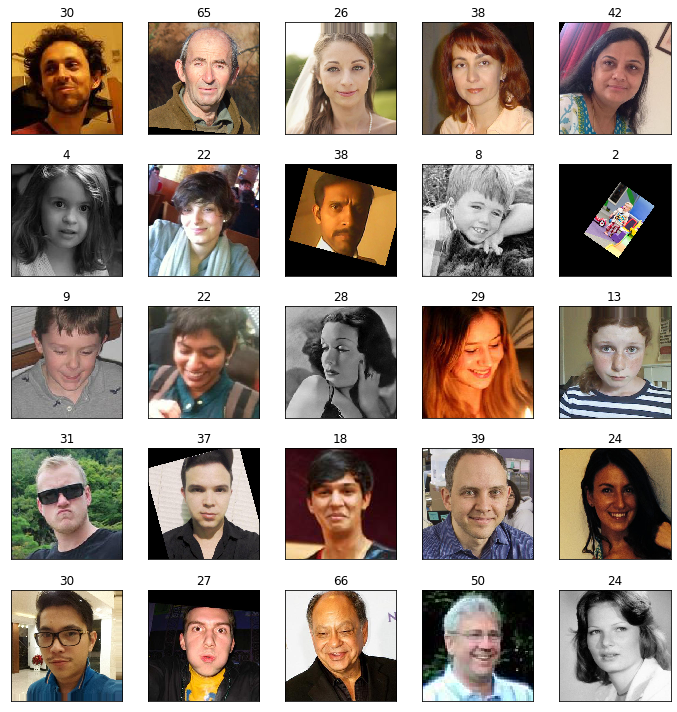

In [14]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

1. Выборка состоит и 7591 цветного изображения разрешением 224 на 224 пикселя.
2. Средний возраст людей на фотографиях - 31 год.
3. Боксплот показывает, что фотографии людей возрастом больше 75-и лет находятся в выбросе. Заранее рассчитываем на ошибку для старшего поколения.
5. При выводе случайных изображений обнаружил изображения:
    - цветные и черно-белые
    - растянутые и сжатые
    - изображения в полный рост
    - изображения низкого качества 
    - на фотографиях присутствуют люди в головных уборах и очках
    - групповые снимки
    - некоторые изображения имеют артефакты и неравномерное освещение
    - различные ракурсы съемки
    - изображения без людей
    - на большинстве изображений лицо находится по центру кадра
6. Чтобы улучшить качество предсказания можно:
    - сделать часть фотографий обучающей выборки черно-белой 
    - обрезать края изображений чтобы избавится от артефактов, затемненных краев и обстановки
    - обогатить выборку зеркальными отражениями

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Вывод:

Train for 356 steps, validate for 119 steps

Epoch 1/10

2020-04-28 21:30:23.303871: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

libcublas.so.10
2020-04-28 21:30:23.607059: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

libcudnn.so.7
356/356 - 52s - loss: 205.4964 - mae: 10.4242 - val_loss: 601.6175 - val_mae: 19.4653

Epoch 2/10
356/356 - 43s - loss: 83.1529 - mae: 6.9429 - val_loss: 146.2858 - val_mae: 9.2020

Epoch 3/10
356/356 - 42s - loss: 58.2686 - mae: 5.8471 - val_loss: 88.4611 - val_mae: 6.9974

Epoch 4/10
356/356 - 42s - loss: 44.1258 - mae: 5.0868 - val_loss: 70.6194 - val_mae: 6.2498

Epoch 5/10
356/356 - 43s - loss: 32.8130 - mae: 4.3712 - val_loss: 92.8724 - val_mae: 7.2839

Epoch 6/10
356/356 - 42s - loss: 24.7160 - mae: 3.8490 - val_loss: 117.0269 - val_mae: 8.1262

Epoch 7/10
356/356 - 42s - loss: 19.6277 - mae: 3.3708 - val_loss: 67.1033 - val_mae: 6.0942

Epoch 8/10
356/356 - 43s - loss: 15.8247 - mae: 3.0570 - val_loss: 70.7307 - val_mae: 6.1681

Epoch 9/10
356/356 - 42s - loss: 13.8072 - mae: 2.8300 - val_loss: 65.6349 - val_mae: 6.0357

Epoch 10/10
356/356 - 42s - loss: 13.8943 - mae: 2.8287 - val_loss: 63.1171 - val_mae: 5.9410

WARNING:tensorflow:sample_weight modes were coerced from
...
to
['...']
119/119 - 10s - loss: 63.1171 - mae: 5.9410

# 3. Анализ обученной модели

5.9410 - ошибка в определении возраста. На трейне модель переобучилась, mae = 2.8287, на валиде это не сказалось. Обучена на 10 эпохах на ResNet50 с использованием алгоритма оптимизации Adam(lr=0.0001).
В выборке больше людей в возрасте от 18 до 40 лет. Если количество людей по категориям возрастов буде сопоставимой (в каждой возрастной группе по годам), веротно качество модели возможно будет максимально поднять.